In [998]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from pandas import read_csv
from sklearn.utils import shuffle
from datetime import datetime
from pandas.core.computation.check import NUMEXPR_INSTALLED
import seaborn as sns

### Cleaned Data without changes

### 1. Daten werden geladen

In [999]:
#lade einfache Daten und wandle in einen Dataframe um
with open('fullData.json') as dataJson:
    data = json.load(dataJson)

In [1000]:
df_data = pd.DataFrame(data)
df = df_data[df_data['session'].notna()]

df.head()

,clientId,elementId,timeStamp,type,siteName,date,clientX,clientY,session,height,width,browser,key
339,2567c85a-ad16,inputPet,824.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:24.171Z,673,363,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
340,2567c85a-ad16,inputPet,858.2999999988824,mouseout,TestEinfach,2022-10-17T13:35:24.205Z,772,333,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
341,2567c85a-ad16,inputCountry,2005.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:25.361Z,796,266,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN
342,2567c85a-ad16,inputCountry,2296.5,focus,TestEinfach,2022-10-17T13:35:25.652Z,NaN,NaN,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,Chrome,NaN
343,2567c85a-ad16,inputHouse,2875.2999999988824,mouseover,TestEinfach,2022-10-17T13:35:26.230Z,995,264,1ff12350-5d06-5a07-9f0d-96a9a3942adb,944,1920,NaN,NaN


### 2. Bereinigung der Daten

#### 2.1 Alle Ereignisse abrufen, die sich tatsächlich in TestSchwer befinden

In [1001]:
#get all events which are actually in TestSchwer
array_input_schwer = ['inputHobby','inputCancelor','inputTemperature','inputDays','inputRiver', 'inputDifficultQuestion', 'clickHere', 'buttonYes', 'alibiClick']

df_einfach_without_schwerInput = df[~df['elementId'].isin(array_input_schwer)]
df_schwer_without_einfachInput = df[df['elementId'].isin(array_input_schwer)]

df_actually_schwer = df_einfach_without_schwerInput.loc[df_einfach_without_schwerInput['siteName'] == 'TestSchwer']
df_easy = df_actually_schwer.assign(sitename='TestSchwer')

df_einfach = df_einfach_without_schwerInput.loc[~(df_einfach_without_schwerInput['siteName'] == 'TestSchwer')]
df_schwer = pd.concat([df_easy, df_schwer_without_einfachInput])
df_schwer['siteName'] = 'TestSchwer'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 20)

#### 2.2 Gleich viele Sessions bei TestSchwer & TestEinfach

In [1002]:
sessionIdSchwer = df_schwer['session']
sessionIdEinfach = df_einfach['session']

df_einfach['is_duplicated'] = df_einfach.duplicated('session')
#89 ids auf Seite Einfach
setEinfach = set(sessionIdEinfach)
length = len(setEinfach)
print(length)

#70 ids auf Seite Schwer
df_schwer['is_duplicated'] = df_schwer.duplicated('session')
setSchwer = set(sessionIdSchwer)
lengthSchwer = len(setSchwer)
print(lengthSchwer)

89
70


<ipython-input-1002-2d14dad677d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_einfach['is_duplicated'] = df_einfach.duplicated('session')


In [1003]:
in_schwer_but_not_in_einfach = setSchwer - setEinfach
in_einfach_but_not_in_schwer = setEinfach - setSchwer

array_einfach = list(in_einfach_but_not_in_schwer)
array_schwer = list(in_schwer_but_not_in_einfach)

#66 Teilnehmer bzw. Sessions
df_einfach_without_ids = df_einfach[~df_einfach['session'].isin(array_einfach)]
df_schwer_without_ids = df_schwer[~df_schwer['session'].isin(array_schwer)]

df_einfach_final = df_einfach_without_ids.drop(['clientId', 'is_duplicated'], axis=1)
df_schwer_final = df_schwer_without_ids.drop(['clientId', 'is_duplicated'], axis=1)

print("Anzahl der Session-Ids bei einfach", 89 - len(array_einfach))
print("Anzahl der Session-Ids bei schwer",70 - len(array_schwer))

Anzahl der Session-Ids bei einfach 66
Anzahl der Session-Ids bei schwer 66


In [1004]:
print(df_einfach_final['session'].value_counts())
print('Anzahl der Events von TestEinfach:',len(df_einfach_final))

69e36b9c-46ec-e499-4a8c-9590b2ca8695    595
6c81bd46-f25a-08fe-9f88-6652cefdf249    275
ea50816c-8d4f-5629-a078-c048513d4fd6    253
2e506528-adcc-8870-92ab-5c8d36f84add    226
849db5c6-9138-0fdc-1a4b-86e89ab9acd3    214
                                       ... 
efb4f373-decb-6b63-194f-b7acb93cf94d     18
bbf7e1d0-6d9a-2025-fce7-45a86117014a     16
fd6c4243-c30d-f1ff-f22e-c2f56b2cf901     14
a42e916e-1d9b-51f0-19ed-f4262b0d1c70     10
da1c188a-f46a-25bf-af34-c8e3afa30304      2
Name: session, Length: 66, dtype: int64
Anzahl der Events von TestEinfach: 4086


In [1005]:
print(df_schwer_final['session'].value_counts())
print('Anzahl der Events von TestSchwer:',len(df_schwer_final))

2e506528-adcc-8870-92ab-5c8d36f84add    4338
b721640b-042e-77a9-9864-28c0ce5264fb    2780
6c81bd46-f25a-08fe-9f88-6652cefdf249    2263
69e4a6b4-0c82-f9be-c9d2-ea959fb5ac90    1678
90ab4d9b-1f2b-12d8-0607-da60d299f472    1591
                                        ... 
bbf7e1d0-6d9a-2025-fce7-45a86117014a       9
da1c188a-f46a-25bf-af34-c8e3afa30304       7
a2182a9f-b55f-ad7c-0744-9c3106331d5d       6
24027ad1-57b0-1b05-d2b4-55d6d4e1bf65       5
35e42b1c-1ae0-9ab7-b1cb-9bc03f17b034       4
Name: session, Length: 66, dtype: int64
Anzahl der Events von TestSchwer: 31078


#### 2.3 Diskrepanz der Daten analysieren

In [1006]:
df_concat_data = pd.concat([df_schwer_final, df_einfach_final])

Text(0.5, 1.0, 'Count for Events')

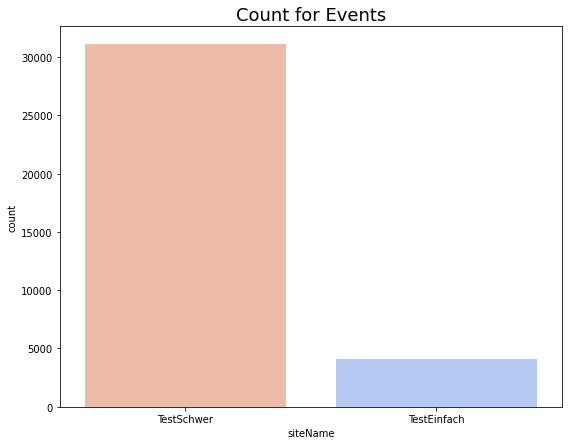

In [1007]:
# Figure size
plt.figure(figsize=(9,7))
# Count plot
ax = sns.countplot(x = 'siteName', data = df_concat_data, palette="coolwarm_r")
# Add title
plt.title('Count for Events', fontsize=18)

Text(0.5, 1.0, 'Counts for Types')

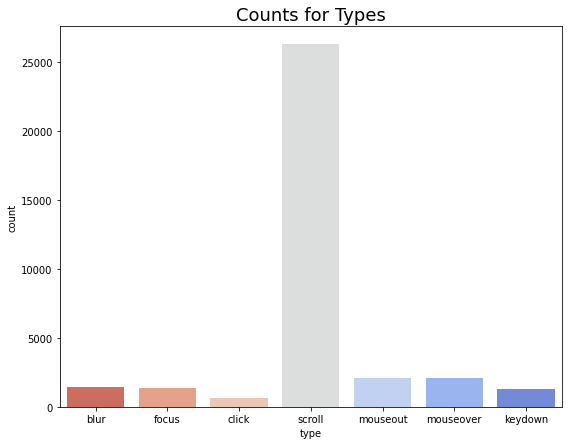

In [1008]:
# Figure size
plt.figure(figsize=(9,7))
# Count plot
ax = sns.countplot(x = 'type', data = df_concat_data, palette="coolwarm_r")
# Add title
plt.title('Counts for Types', fontsize=18)

In [1009]:
df_einfach_final = df_einfach_final.loc[df_einfach_final["type"] !="scroll"]
df_schwer_final = df_schwer_final.loc[df_schwer_final["type"] !="scroll"]

In [1010]:
print('Anzahl der Events ohne Scroll von TestEinfach:',len(df_einfach_final))
print('Anzahl der Events ohne Scroll von TestSchwer:',len(df_schwer_final))

Anzahl der Events ohne Scroll von TestEinfach: 1603
Anzahl der Events ohne Scroll von TestSchwer: 7279


#### 2.4 Werte in float umwandeln

In [1011]:
array_of_properties = ['timeStamp', 'clientX', 'clientY', 'height', 'width']

In [1012]:
def toFloat(test, array):
    for x in range(5): 
        test[array[x]] = test[array[x]].astype(float)
    test['date'] = test['date'].astype('datetime64[ns]')

toFloat(df_einfach_final, array_of_properties)
toFloat(df_schwer_final, array_of_properties)

#### 2.5 Fehlende Werte entfernen

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:238: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<Figure size 720x432 with 0 Axes>

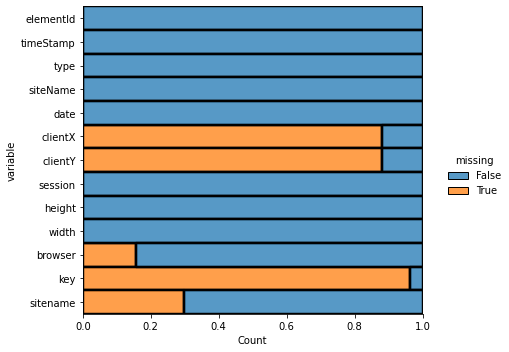

In [1013]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df_concat_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)

In [1014]:
df_einfach_final = df_einfach_final.drop(['key', 'browser'], axis=1)
df_schwer_final = df_schwer_final.drop(['key', 'browser', 'sitename'], axis=1)

In [1015]:
df_einfach_final['clientX'].fillna((df_einfach_final['clientX'].mean()), inplace=True)
df_einfach_final['clientY'].fillna((df_einfach_final['clientY'].mean()), inplace=True)

df_schwer_final['clientX'].fillna((df_schwer_final['clientX'].mean()), inplace=True)
df_schwer_final['clientY'].fillna((df_schwer_final['clientY'].mean()), inplace=True)

In [1016]:
df_concat_data = pd.concat([df_einfach_final, df_schwer_final])

/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:238: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  curves.iloc[:, cols] = (curves
/Users/ingaglotzbach/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:243: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


<Figure size 720x432 with 0 Axes>

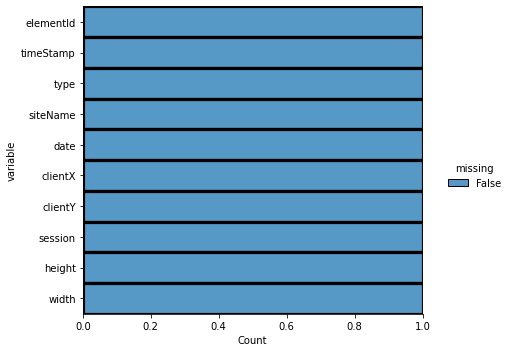

In [1017]:
#test if something is missing 
plt.figure(figsize=(10,6))
sns.displot(
    data=df_concat_data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.savefig("visualizing_missing_data_with_barplot_Seaborn_distplot.png", dpi=100)

In [1018]:
df_einfach_final['siteName'] = 0
df_schwer_final['siteName'] = 1

df_concat_data = pd.concat([df_einfach_final, df_schwer_final])

In [1072]:
df_schwer_final = df_schwer_final.loc[(df_schwer_final['timeStamp'] < 3000000)]

### 3.0 Explorative Datenanalyse

<AxesSubplot: xlabel='timeStamp', ylabel='type'>

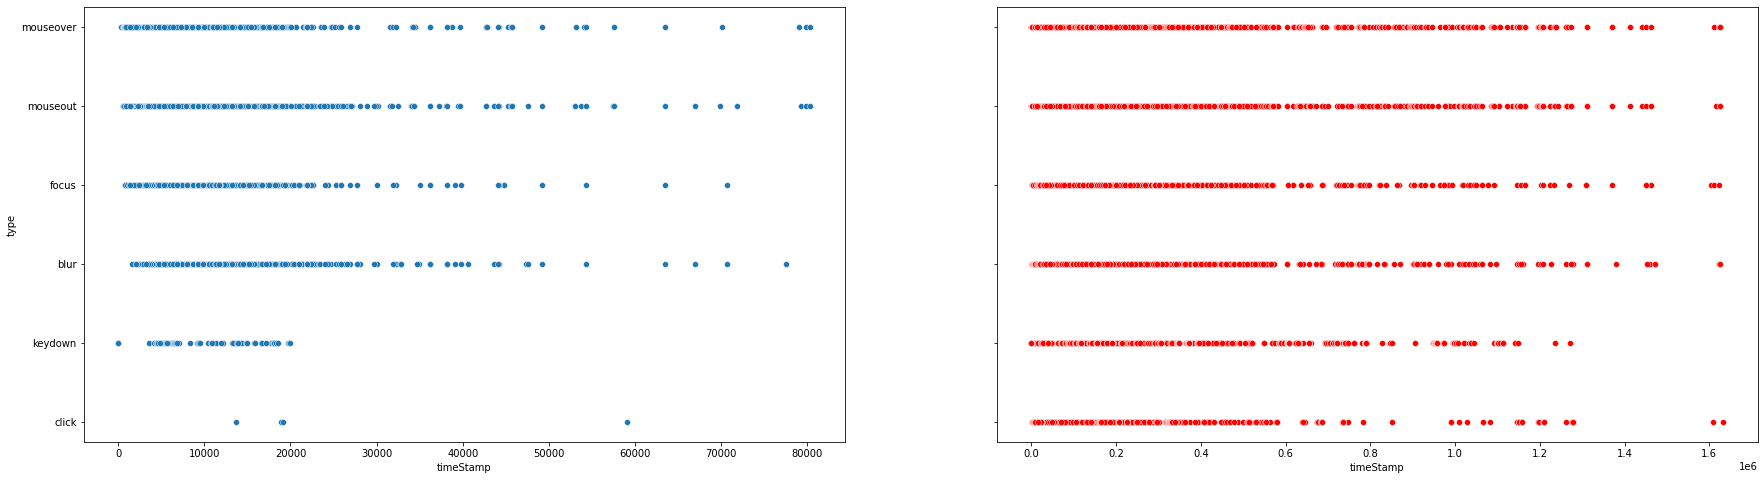

In [1075]:
fig2, axs2 = plt.subplots(1,2, figsize=(30,8), sharey=True)

sns.scatterplot(data=df_einfach_final, x='timeStamp', y='type', ax=axs2[0])
sns.scatterplot(data=df_schwer_final, x='timeStamp', y='type', ax=axs2[1], color='red')

In [ ]:
array_session_einfach = ['f3a6d5da-7857-ab9a-bcaf-ffa678540500', '0eb0e508-a337-0a7e-490d-5bb67ea8605a', '7e78ac93-8a2f-39d2-26a1-c41c7804b2e2', 'c9f551e4-927d-b2bf-aa77-6c49231d51df', 'edeac185-2198-1a32-1bf4-dd0816811064', 'd6e55e9b-a662-53a8-a261-4a0a362e30c3', '06d4d87e-940f-973f-a09f-74fff7d0b83a', '8abf06f5-52ae-6b8a-2203-b8e5967621d3', '51f4db5a-4b60-df29-b773-12ad99d4781e', '0a0fdcc9-ebf8-371b-40bf-efe88d97e22e', 'f4fd1505-cec6-5f69-18de-bceac07666e6', 'c84ddb60-e23a-cd84-ab83-ba030d4c4a73', 'fba8ac2f-02c2-130b-254f-3bcebe67d451', 'f090c908-bb4c-fdca-942d-6ae02b4019b0', '62c1e7a3-3ae8-ea78-a6fa-5b0c8e6a4b90', 'a8edf9d6-fb31-5690-e4be-3fa68ae2ff4a', 'ce22d53f-16a7-8e19-de32-641cffee9cae', 'c2fccaf4-aa23-d3bb-291b-2ce8e083512a', 'cde8b105-35ba-2b75-2f62-7d2d538c9dca', '047b635d-224e-f897-c995-3a9cac2df78a', '5db6c1c8-a5d3-37a1-848e-71c29c4dd002', 'b66c82e2-5869-5ecc-0d81-1c7d55671ec8', '7fe95a48-d9bd-2059-b731-0da1e54a4618']
df_click_einfach = df_einfach[df_einfach['session'].isin(array_session_einfach)]

#df_click_einfach['session'].value_counts()

df_click_einfach.loc[df_click_einfach['elementId'] == 'inputEasyQuestion']
df_click_einfach.sort_values(['session', 'timeStamp'])
df_sroll = df_click_einfach.loc[df_click_einfach["type"] !="scroll"]

df_sroll['session'].value_counts()


# df_click_einfach.sort_values(['session', 'timeStamp'])
# df = df_click_einfach.loc[df_click_einfach['elementId'] == 'inputEasyQuestion']

c84ddb60-e23a-cd84-ab83-ba030d4c4a73    39
5db6c1c8-a5d3-37a1-848e-71c29c4dd002    27
ce22d53f-16a7-8e19-de32-641cffee9cae    25
f3a6d5da-7857-ab9a-bcaf-ffa678540500    13
c9f551e4-927d-b2bf-aa77-6c49231d51df    10
                                        ..
f4fd1505-cec6-5f69-18de-bceac07666e6     2
d6e55e9b-a662-53a8-a261-4a0a362e30c3     1
06d4d87e-940f-973f-a09f-74fff7d0b83a     1
b66c82e2-5869-5ecc-0d81-1c7d55671ec8     1
cde8b105-35ba-2b75-2f62-7d2d538c9dca     1
Name: session, Length: 22, dtype: int64

In [ ]:
schwero = pd.read_pickle('CleanedDataWithIds.pkl')

schwer = schwero.loc[schwero['siteName'] == 'TestSchwer']
schwer_click = schwer.loc[schwer['elementId'] == 'clickHere']
schwer_nextButton = schwer.loc[schwer['elementId'] == 'nextButton']
schwer_key = schwer.loc[schwer['type'] == 'keydown']

#schwer_click['session'].value_counts()
#schwer_nextButton['session'].value_counts()
schwer_key['session'].value_counts()



544    197
985     86
337     76
365     72
650     63
      ... 
744      4
691      4
631      4
468      2
904      1
Name: session, Length: 44, dtype: int64

In [ ]:
einfach = schwero.loc[schwero['siteName'] == 'TestEinfach']
einfach_key = einfach.loc[einfach['type'] == 'keydown']

einfach_key['session'].count()

91

In [ ]:
df_data_without_scroll = pd.concat([df_einfach_final, df_schwer_final])
df_data_without_scroll = df_data_without_scroll.loc[df_data_without_scroll["type"] !="scroll"]
df_tmp = shuffle(df_data_without_scroll)
#df_tmp.to_pickle('CleanedDataWithoutChange.pkl')

In [ ]:
df_einfach_final['type'].value_counts()

mouseover    380
mouseout     379
blur         375
focus        374
keydown       91
click          4
Name: type, dtype: int64

Text(0.5, 1.0, 'Counts for Types')

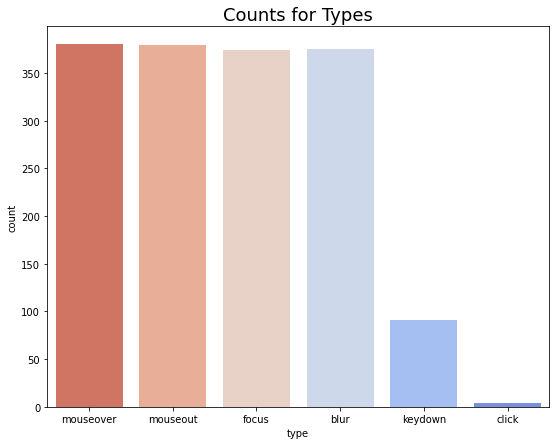

In [ ]:
#count of easy
# Figure size
plt.figure(figsize=(9,7))
# Count plot
ax = sns.countplot(x = 'type', data = df_einfach_final, palette="coolwarm_r")
# Add title
plt.title('Counts for Types', fontsize=18)

In [ ]:
df_schwer_final['type'].value_counts()

mouseover    1706
mouseout     1696
keydown      1222
blur         1028
focus        1002
click         625
Name: type, dtype: int64

Text(0.5, 1.0, 'Counts for Types')

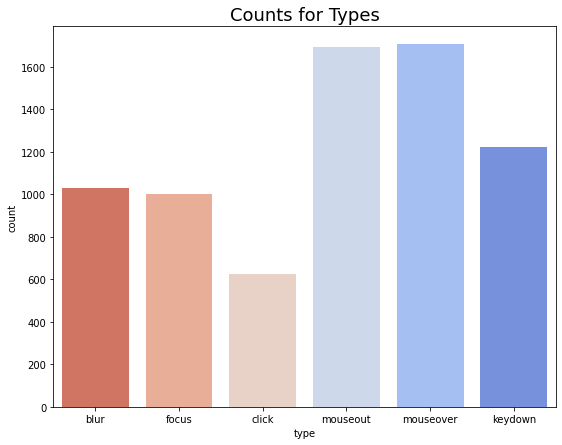

In [ ]:
#count of easy
# Figure size
plt.figure(figsize=(9,7))
# Count plot
ax = sns.countplot(x = 'type', data = df_schwer_final, palette="coolwarm_r")
# Add title
plt.title('Counts for Types', fontsize=18)

In [ ]:
df_schwer_final = df_schwer_final.loc[df_schwer_final["type"] !="scroll"]
df_einfach_final = df_einfach_final.loc[df_einfach_final["type"] !="scroll"]

In [ ]:
# df2 = df_einfach_final.sort_values(['session', 'date'],
#               ascending = [True, True])

In [ ]:
# print(len(df_einfach_final))
# print(len(df_schwer_final))

# df_einfach_final['type'].value_counts()


In [ ]:
# df_schwer_final['type'].value_counts()

In [ ]:
df_data_without_scroll = df_data_without_scroll.loc[df_data_without_scroll["type"] !="scroll"]
df_data_without_scroll['siteName'] = df_data_without_scroll['siteName'].replace('TestSchwer', 1)
df_data_without_scroll['siteName'] = df_data_without_scroll['siteName'].replace('TestEinfach', 0)

### Cleaned Data with other session Ids

In [ ]:
# new sessionId 
import random
from random import choice
import collections

array_of_ids_einfach = df_einfach_final['session'].value_counts().index.tolist()
array_of_ids_schwer = df_schwer_final['session'].value_counts().index.tolist()
numbers_schwer = []

random_numbers_ids_einfach = random.sample(range(101,1000), len(array_of_ids_einfach))
for i in range(len(random_numbers_ids_einfach)):
    random_numbers_ids_schwer = random.choice([i for i in range(101, 1000) if i not in random_numbers_ids_einfach])
    numbers_schwer.append(random_numbers_ids_schwer)

numbers = random_numbers_ids_einfach + numbers_schwer

df_einfach_final['session'] = df_einfach_final['session'].replace(array_of_ids_einfach, random_numbers_ids_einfach)
df_schwer_final['session'] = df_schwer_final['session'].replace(array_of_ids_schwer, numbers_schwer)

print([item for item, count in collections.Counter(numbers).items() if count > 1])

[786]


In [ ]:
df_new_ids = pd.concat([df_einfach_final, df_schwer_final])

In [ ]:
#df_new_ids.to_pickle('CleanedDataWithIds.pkl')

In [ ]:
import imblearn
print(imblearn.__version__)

0.9.1


In [ ]:
df_sessions = pd.read_pickle('SortedBySessions.pkl')

In [ ]:
df_sessions.head()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration,height,width,siteName
0,517,13,13,4,23,22,9,528.129,661,360,TestSchwer
1,534,5,5,0,6,6,2,12.241,664,390,TestEinfach
3,543,6,6,0,6,6,4,19.673,669,390,TestEinfach
4,544,256,256,33,117,116,197,1270.171,962,1724,TestSchwer
5,546,32,32,7,26,28,27,135.360,1312,1479,TestSchwer


In [ ]:
df_cleaned = pd.read_pickle('CleanedDataWithIds.pkl')


In [ ]:
one_hot_encoded_data = pd.get_dummies(df_cleaned, columns = ['elementId', 'type'])

In [ ]:
# import seaborn as sns
# sns.scatterplot(data=df_cleaned, x="type", y="timeStamp", hue="siteName")

In [ ]:
# sns.scatterplot(data=df_data_without_scroll, x="timeStamp", y="type", hue="siteName")

In [ ]:
# einfach = df_data_without_scroll.loc[df_data_without_scroll['siteName'] == 0]
# schwer = df_data_without_scroll.loc[df_data_without_scroll['siteName'] == 1]

<AxesSubplot: xlabel='timeStamp', ylabel='type'>

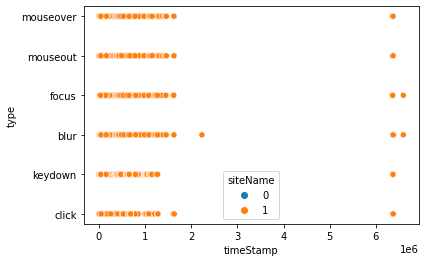

In [1022]:
sns.scatterplot(data=df_data_without_scroll, x='timeStamp', y="type", hue="siteName")

<AxesSubplot: xlabel='timeStamp', ylabel='type'>

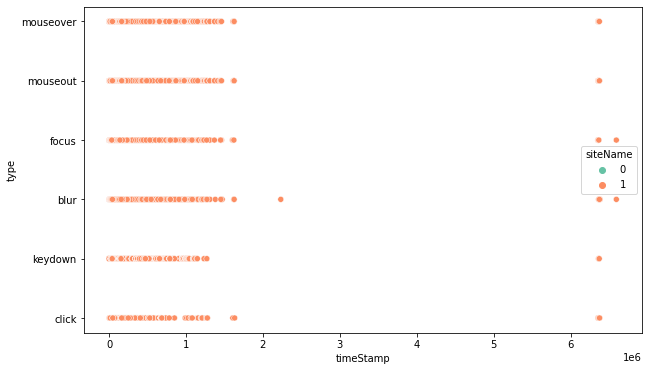

In [1023]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_data_without_scroll, x='timeStamp', y="type", hue="siteName", palette="Set2")

In [ ]:
df_sessions.head

<bound method NDFrame.head of      session  count_mouseover  count_mouseout  count_click  count_blur  \
0        517               13              13            4          23   
1        534                5               5            0           6   
3        543                6               6            0           6   
4        544              256             256           33         117   
5        546               32              32            7          26   
..       ...              ...             ...          ...         ...   
124      985               27              26           18          38   
125      474               15              15            0           6   
127      479               14              14            2          14   
128      998                6               6            0           6   
129      488              104             104           23          44   

     count_focus  count_keydown  duration height width     siteName  
0          

In [ ]:
df_session_einfach = df_sessions.loc[df_sessions["siteName"] == "TestEinfach"]
df_session_schwer = df_sessions.loc[df_sessions["siteName"] == "TestSchwer"]

In [ ]:
df_session_einfach.describe()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,607.561404,6.070175,6.052632,0.070175,6.228070,6.210526,1.596491,23.239491
std,257.836120,3.189602,3.203910,0.257713,0.681845,0.647436,2.396870,12.724174
min,109.000000,1.000000,1.000000,0.000000,4.000000,4.000000,0.000000,8.030000
25%,390.000000,4.000000,4.000000,0.000000,6.000000,6.000000,0.000000,17.076000
50%,633.000000,6.000000,6.000000,0.000000,6.000000,6.000000,0.000000,18.556000
75%,833.000000,6.000000,6.000000,0.000000,6.000000,6.000000,3.000000,25.193000
max,998.000000,17.000000,17.000000,1.000000,8.000000,8.000000,11.000000,79.181000


In [ ]:
df_session_schwer.describe()

,session,count_mouseover,count_mouseout,count_click,count_blur,count_focus,count_keydown,duration
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,549.508772,28.719298,28.543860,8.228070,17.263158,16.877193,21.245614,271.991123
std,265.732688,39.630325,39.729024,11.602059,17.621544,17.625134,32.214837,297.877191
min,128.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,8.900000
25%,337.000000,8.000000,7.000000,1.000000,7.000000,6.000000,0.000000,78.159000
50%,544.000000,17.000000,17.000000,4.000000,14.000000,14.000000,7.000000,210.760000
75%,744.000000,39.000000,39.000000,9.000000,24.000000,23.000000,29.000000,340.030000
max,985.000000,256.000000,256.000000,63.000000,117.000000,116.000000,197.000000,1623.542000


In [ ]:
# #next Button wurde anscheinend nicht immer übertragen lol --> deswegen müssen wir schauen ob die gleich adresse auf der anderne Seite ist 
# df_test = df_einfach_final.loc[df_einfach_final['elementId'] == 'nextButton']
# print(df_test)